In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,5]
data = pd.read_csv("multiTimeline_diet.csv",skiprows=[0,1], index_col='Week', parse_dates=['Week'])


from sklearn.model_selection import train_test_split

In [38]:
data.head()

,diet: (United States)
Week,
2016-03-27,58
2016-04-03,63
2016-04-10,59
2016-04-17,59
2016-04-24,58


In [39]:
data.rename(columns={'diet: (United States)':'diet'}, inplace=True)

In [40]:
data.head()

,diet
Week,
2016-03-27,58
2016-04-03,63
2016-04-10,59
2016-04-17,59
2016-04-24,58


<Axes: xlabel='Week'>

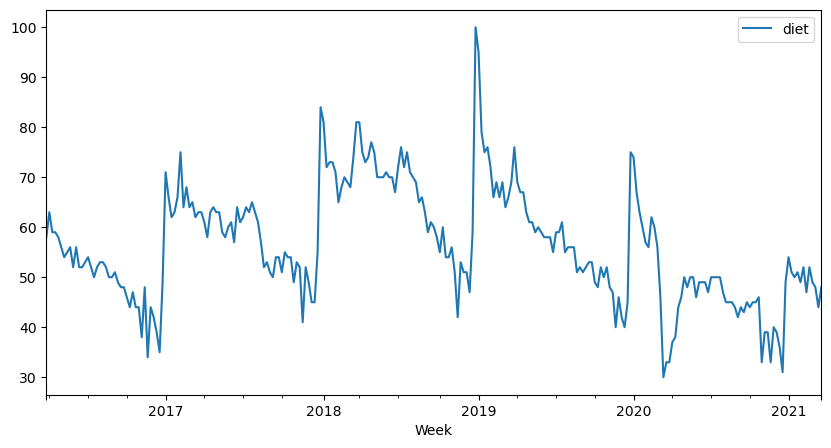

In [41]:
data.plot()

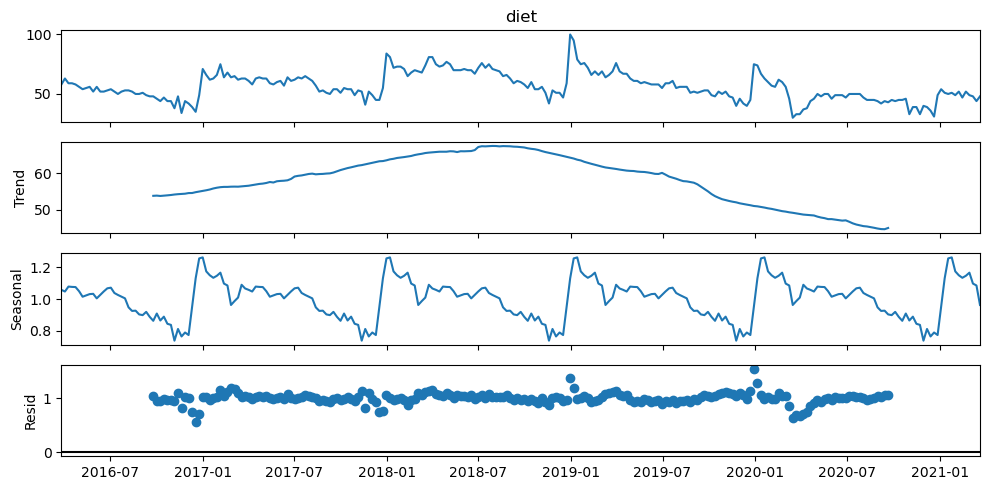

In [42]:
# With the graph it is quite evident that there is a trend as well as seasonality is eveident in the data. 

# The seasonality can the iterpreted from the simillar pattern repeating every  year.

# Now we will detrend and analyse the data
# As we already know that there are two types of decomposition models namely additive and multiplicative

import statsmodels.api as sm

dcmp = sm.tsa.seasonal_decompose(data['diet'], model='multiplicative', period=53 
                                 #53 weeks in a year
                                 )

fig = dcmp.plot()


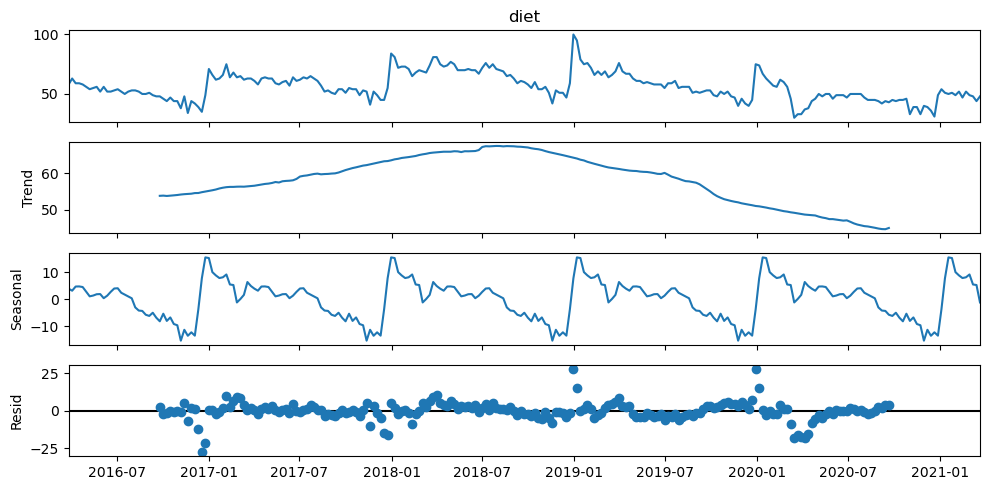

In [43]:
# Lets try with additive model

import statsmodels.api as sm

dcmp = sm.tsa.seasonal_decompose(data['diet'], model='additive', period=53 
                                 #53 weeks in a year
                                 )

fig = dcmp.plot()

In [44]:
# Next we should perform the stationarity tests
# which are ADF and KPSS

# ADF -- null says the ts is not stationary
# KPSS -- null says the ts is stationary


# ADF  test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts):
    print("ADF Test")
    dftest = adfuller(ts, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [45]:
# Simillar for KPSS test
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [46]:
adf_test(data['diet']), kpss_test(data['diet'])

ADF Test
Test Statistic                  -2.862178
p-value                          0.049926
#Lags Used                       6.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64
Results of KPSS Test:
Test Statistic           0.630337
p-value                  0.019878
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


(None, None)

In [47]:
# for the adf test p is below threshold and hence null is accepted,means series is not stationary
# for the kpss test p is below threshold and hence null is accepted, means series is stationary

# for kpss indicating sationary and ADF indicating non-stationary, the series is trend stationary and hence the trend needs to be removed to make the ts strict stationary.

# for kpss indicating non-stationary and ADF indicating starionariy- The series is difference stationary and hence differencing is used ot make the series stationary. After that, the differenced seris is checked for stationarity


# the test results match with the 2nd statement



In [48]:
# Very common way to make a series stationary is to substract the present value from the previous value

def obtain_adf_kpss_result(timeseries, max_d):
    results=[]

    for i in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags='auto')
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <= 0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True


        # for the series to be stationary both has to be true
        stationary = adf_stationary & kpss_stationary
        results.append((i,adf_result[1], kpss_result[1], adf_stationary, kpss_stationary, stationary))

    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])
    
    return results_df

In [49]:
obtain_adf_kpss_result(data['diet'], 3)

,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,4.992622e-02,0.019878,True,False,False
1,1,1.171221e-13,0.100000,True,True,True
2,2,2.761322e-12,0.100000,True,True,True


<Axes: title={'center': 'Original Time Series'}, xlabel='Week'>

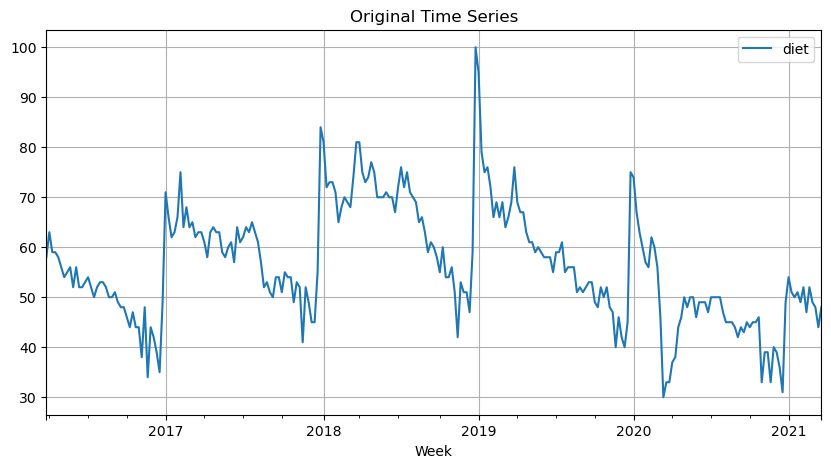

In [50]:
# Very clear that differenceing will make the data stationary
data.plot(grid=True, figsize=(10,5), title="Original Time Series")

<Axes: title={'center': 'One differenced stationary time series'}, xlabel='Week'>

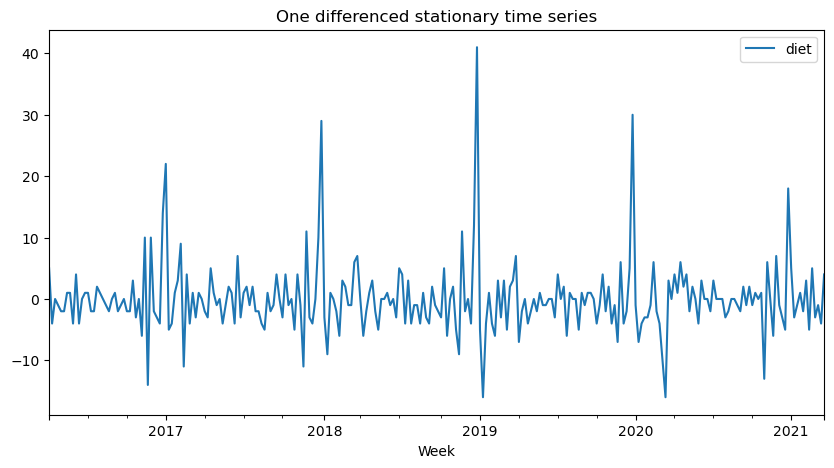

In [51]:
# plot after differencing

data.diff().dropna().plot(figsize=(10,5), title="One differenced stationary time series")

## SARIMAX models

In [52]:
#ARIMA model- AR which uses lagged values of time series to forcast and MA is moving average which uses lagged values of residuals to forecast data.

# We cannot forecast if the data is not stationary. However we need to transform the time series back to its original form to access the transformed values

# ARIMA comprises of p,d,q where p is number of autoregressive lags, d is the times the series is differenced to make it sationary and q is the number of moving average lags

# ARIMA(p,d,q)

# p=1,d=0,q=0

# ARIMA(1,0,0)

# ARIMA(1,0,0)

# To select the number of differencing we can use ADF and KPSS tests


#////////////////////////////////////////////////////////////////////////////////

# ARIMAX model
# X stands for exogenous inputs
# For example, when modeling the waiting time in an emergency room. The number of nurses available at a certain shift could be considered an external variable since it may have impact on the waiting time. If this is indeed the case, we can affect the waiting times by changing the number of nurses .

#////////////////////////////////////////////////////////////////////////////////////////

# SARIMA model

# When applyring ARIMA models we care ignoring seasonality and using only part of th einformation in the data. As a consequence we are not making the best predictions possible


# SARIMA is defined by SARIMA(p,d,q)(P,D,Q,S)

#where P is seasonal differencing order, D is seasonal differencing order and Q is Seasonal moving average order
# S is the lenght of the Seasonal Cycle.





In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning, InterpolationWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', InterpolationWarning)




ARIMA

In [54]:
from statsmodels.tsa.stattools import adfuller, kpss

In [55]:
df = pd.read_csv('walmart_train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [56]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [58]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=20, shuffle=True)

In [59]:
df_test.shape, df_train.shape

((273900, 4), (639100, 4))

In [60]:
df_train.groupby('store').nunique()['item']

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [61]:
df_test.groupby('store').nunique()['item']

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [62]:
df_train['date'], df_test['date'] = pd.to_datetime(df_train['date']), pd.to_datetime(df_test['date'])

In [63]:
df_train['date'].min(), df_test['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [ ]:
store_sales = df_test[['store','sales']].groupby('store').sum().sort_values('sales', ascending=False)


<Axes: title={'center': 'No of sales per store'}, xlabel='store', ylabel='sales'>

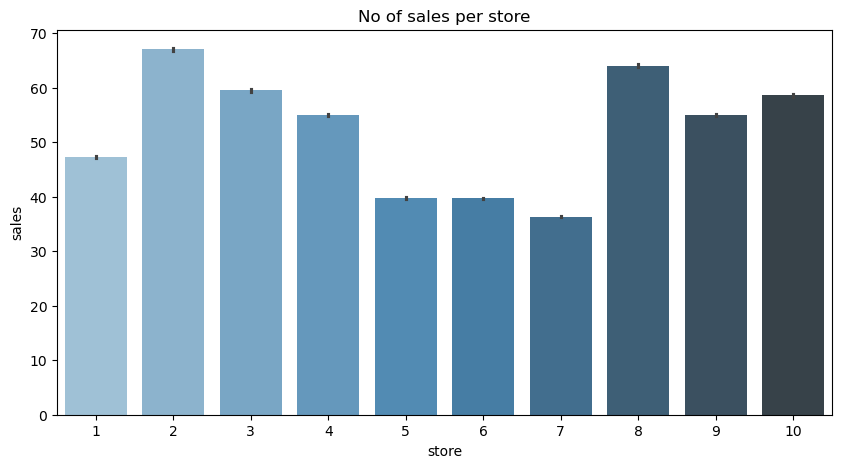

In [74]:
plt.title("No of sales per store")
sns.barplot(data=df_train, x='store', y='sales', palette='Blues_d')

In [77]:
# Clearly the store no 7 has the lowest vol of sales among the stores

# lets analyze the store

df_train_7 = df_train[df_train['store'] == 7].drop('store',axis=1)
df_train_7.tail()

,date,item,sales
321515,2013-05-20,18,36
231251,2016-03-21,13,43
686822,2013-09-04,38,59
11003,2013-02-17,1,16
285919,2015-11-30,16,18


In [82]:
df_train_7[['item', 'sales']].groupby('item').sum().sort_values('sales', ascending=False).head()

Index(['sales'], dtype='object')

<Axes: xlabel='item', ylabel='sales'>

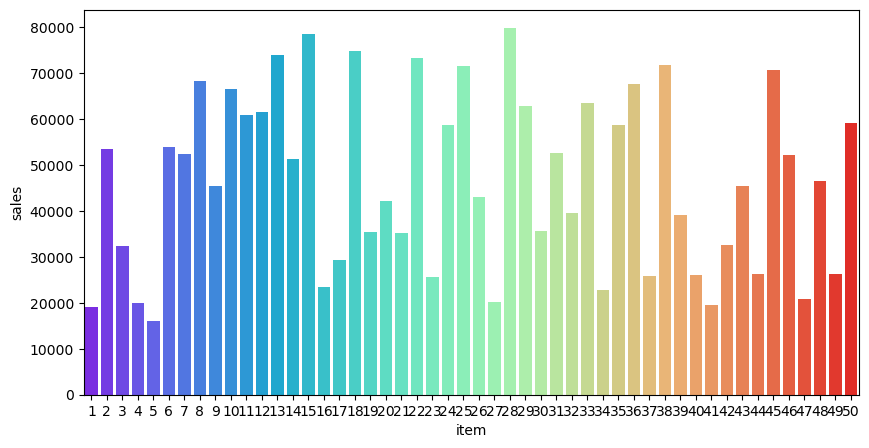

In [85]:
sns.barplot(data=df_train_7[['item', 'sales']].groupby('item').sum().sort_values('sales', ascending=False), x='item', y='sales',palette='rainbow')

In [110]:
# Create some time related columns
df_train_7['year'] = df_train_7['date'].dt.year
df_train_7['month'] = df_train_7['date'].dt.month
df_train_7['day'] = df_train_7['date'].dt.dayofyear
df_train_7['weekday'] = df_train_7['date'].dt.weekday
df_train_7['year-month'] = df_train_7['date'].apply(lambda x: str(x.year)+'-'+str(x.month))


In [111]:
df_train_7.tail()

,date,item,sales,year,month,day,weekday,year-month
321515,2013-05-20,18,36,2013,5,140,0,2013-5
231251,2016-03-21,13,43,2016,3,81,0,2016-3
686822,2013-09-04,38,59,2013,9,247,2,2013-9
11003,2013-02-17,1,16,2013,2,48,6,2013-2
285919,2015-11-30,16,18,2015,11,334,0,2015-11


<Axes: title={'center': 'sales every weekdays'}, xlabel='weekday', ylabel='sales'>

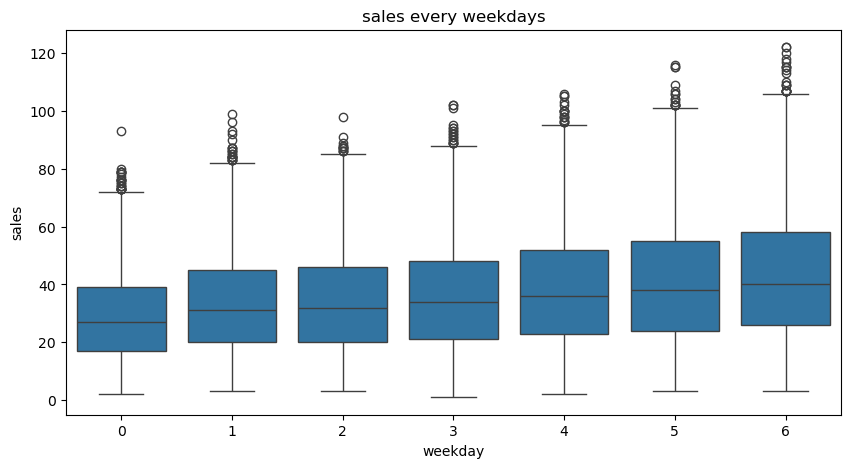

In [112]:
plt.title("sales every weekdays")
sns.boxplot(x='weekday',y='sales', data=df_train_7)

<Axes: title={'center': 'sales per month'}, xlabel='month', ylabel='sales'>

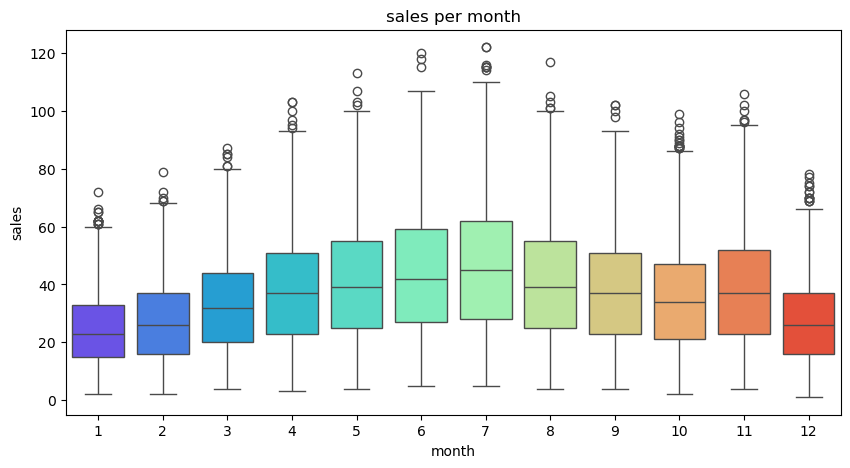

In [116]:
# Clearly the weekends have the highest sales figure

plt.title("sales per month")
sns.boxplot(data=df_train_7, x='month', y='sales', palette='rainbow')


# July has the highest sale and january has the lowest


<Axes: title={'center': 'Sales per Year-Month'}, xlabel='year-month', ylabel='sales'>

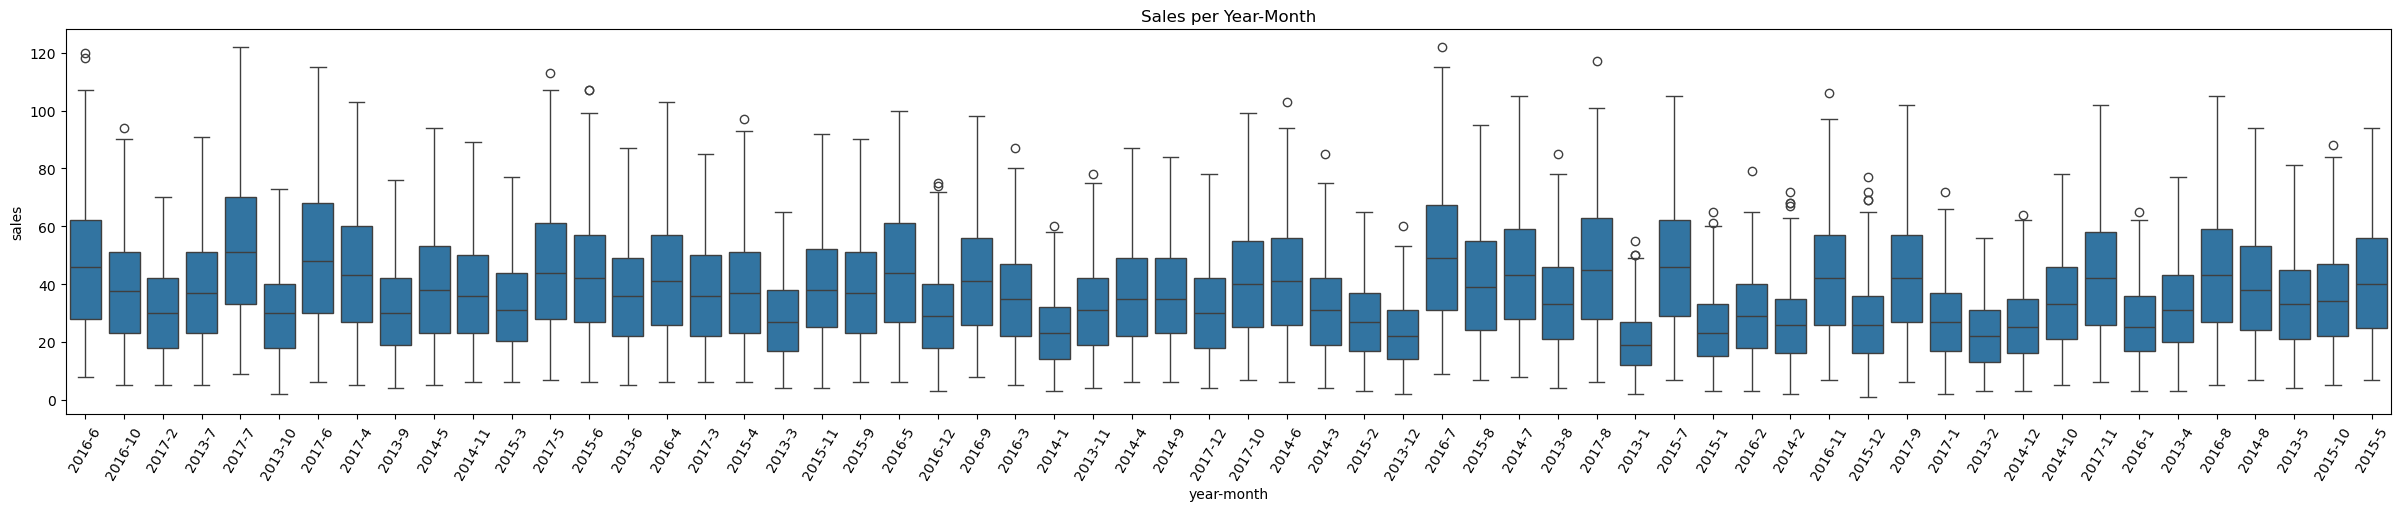

In [119]:
plt.figure(figsize=(30,5))
plt.xticks(rotation=60)
plt.title('Sales per Year-Month')
sns.boxplot(x='year-month', y='sales', data=df_train_7)

<Axes: xlabel='month', ylabel='sales'>

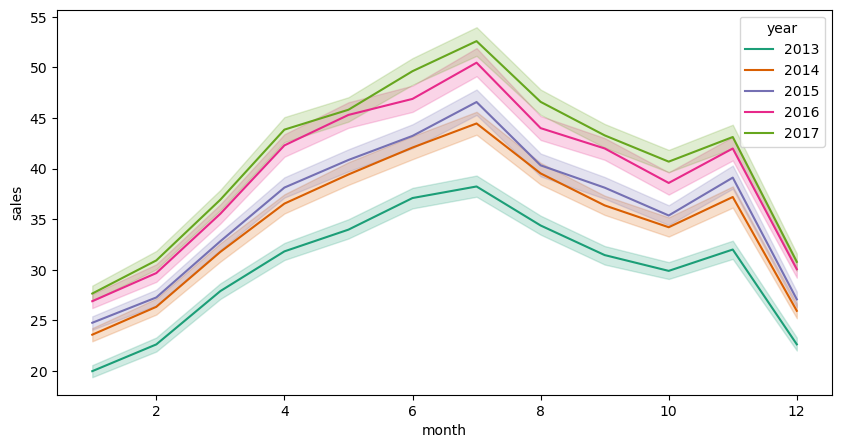

In [120]:
# The sales pattern seems to be pretty same every year


sns.lineplot(data=df_train_7, x='month', y='sales', hue='year', legend='full',palette='Dark2')